In [7]:
import pandas as pd
import numpy as np
import pickle
import argparse
import os

import torch

In [8]:
# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()):
    device = torch.device('cuda:4')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")

Device set to : NVIDIA GeForce RTX 2080 Ti


# Arguments

In [9]:
# @title Arguments
parser = argparse.ArgumentParser(description='Actor Critic')

parser.add_argument('--data', default="/mnt/kerem/CEU", type=str, help='Dataset Path')
parser.add_argument('--epochs', default=64, type=int, metavar='N', help='Number of epochs for training agent.')
parser.add_argument('--episodes', default=10000, type=int, metavar='N', help='Number of episodes for training agent.')
parser.add_argument('--lr', '--learning-rate', default=0.005, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--wd', default=0.0001, type=float, help='Weight decay for training optimizer')
parser.add_argument('--seed', default=3, type=int, help='Seed for reproducibility')
parser.add_argument('--model-name', default="PPO", type=str, help='Model name for saving model.')
parser.add_argument('--gamma', default=0.99, type=float, metavar='N', help='The discount factor as mentioned in the previous section')
parser.add_argument('--val_freq', default=50, type=int, metavar='N', help='Validation frequencies')

# Model
parser.add_argument("--latent1", default=256, required=False, help="Latent Space Size for first layer of network.")
parser.add_argument("--latent2", default=256, required=False, help="Latent Space Size for second layer of network.")

# Env Properties
parser.add_argument('--control_size', default=20, type=int, help='Beacon and Attacker Control group size')
parser.add_argument('--gene_size', default=100, type=int, help='States gene size')
parser.add_argument('--beacon_size', default=60, type=int, help='Beacon population size')
parser.add_argument('--victim_prob', default=0.8, type=float, help='Victim inside beacon or not!')
parser.add_argument('--pop_reset_freq', default=10, type=int, help='Reset Population Frequency (Epochs)')
parser.add_argument('--max_queries', default=10, type=int, help='Maximum queries per episode')


parser.add_argument("--state_dim", default=(4,), required=False, help="State Dimension")
parser.add_argument("--n-actions", default=1, required=False, help="Actions Count for each state")


# utils
parser.add_argument('--resume', default="", type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('--save-dir', default='./results', type=str, metavar='PATH', help='path to cache (default: none)')

# args = parser.parse_args()  # running in command line
args = parser.parse_args('')  # running in ipynb

# set command line arguments here when running in ipynb
if args.save_dir == '':
    args.save_dir = "./"

args.results_dir = args.save_dir

if not os.path.exists(args.results_dir):
      os.makedirs(args.results_dir)

args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(args)

Namespace(data='/mnt/kerem/CEU', epochs=64, episodes=10000, lr=0.005, wd=0.0001, seed=3, model_name='PPO', gamma=0.99, val_freq=50, latent1=256, latent2=256, control_size=20, gene_size=100, beacon_size=60, victim_prob=0.8, pop_reset_freq=10, max_queries=10, state_dim=(4,), n_actions=1, resume='', save_dir='./results', results_dir='./results', device=device(type='cuda'))


# Read Data

In [10]:
# CEU Beacon - it contains 164 people in total which we will divide into groups to experiment
beacon = pd.read_csv(os.path.join(args.data, "Beacon_164.txt"), index_col=0, delim_whitespace=True)
# Reference genome, i.e. the genome that has no SNPs, all major allele pairs for each position
reference = pickle.load(open(os.path.join(args.data, "reference.pickle"),"rb"))
# Binary representation of the beacon; 0: no SNP (i.e. no mutation) 1: SNP (i.e. mutation)
binary = np.logical_and(beacon.values != reference, beacon.values != "NN").astype(int)

In [11]:
# Table that contains MAF (minor allele frequency) values for each position. 
maf = pd.read_csv(os.path.join(args.data, "MAF.txt"), index_col=0, delim_whitespace=True)
maf.rename(columns = {'referenceAllele':'major', 'referenceAlleleFrequency':'major_freq', 
                      'otherAllele':'minor', 'otherAlleleFrequency':'minor_freq'}, inplace = True)
maf["maf"] = np.round(maf["maf"].values, 3)
# Same variable with sorted maf values
sorted_maf = maf.sort_values(by='maf')
# Extracting column to an array for future use
maf_values = maf["maf"].values

In [12]:
beacon.shape, reference.shape, binary.shape, maf_values.shape

((4029840, 164), (4029840, 1), (4029840, 164), (4029840,))

# PPO

In [13]:
has_continuous_action_space = True                

action_std = 0.4                    # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.05        # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.1                # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = int(2.5e5)

################ PPO hyperparameters ################
K_epochs = 64           # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Victim is inside the Beacon!


/mnt/sobhan/Beacons/environment.py:105: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1705951428005/work/torch/csrc/utils/tensor_new.cpp:261.)
  self.attacker_state = torch.tensor([self.victim, self.mafs, [0]*len(self.victim)], dtype=torch.float32).transpose(0, 1)
/mnt/sobhan/cpi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Started training at (GMT) :  2024-04-14 14:19:59
current logging run number for  :  3
logging at : ./results/PPO__log_3.csv
save checkpoint path : ./results/weights/PPO_3.pth
Episode:  0
lrt:  tensor(0.)
preward:  tensor(1.)
ureward:  [-0.46355292]
lrt:  tensor(-1.3267e+29)
preward:  tensor(0.)
ureward:  [-1.305403]
lrt:  tensor(-1.1508e+36)
preward:  tensor(0.)
ureward:  [-1.0638127]
lrt:  tensor(-1.1508e+36)
preward:  tensor(0.)
ureward:  [-0.99445003]
lrt:  tensor(-9.9319e+35)
preward:  tensor(0.)
ureward:  [-1.1644826]
lrt:  tensor(-9.9319e+35)
preward:  tensor(0.)
ureward:  [-0.6649422]
lrt:  tensor(-1.4732e+37)
preward:  tensor(0.)
ureward:  [-0.2645887]
lrt:  tensor(-1.4732e+37)
preward:  tensor(0.)
ureward:  [-0.29464188]
lrt:  tensor(-1.4732e+37)
preward:  tensor(0.)
ureward:  [0.52863884]
lrt:  tensor(-1.4732e+37)
preward:  tensor(0.)
ureward:  [0.7873981]
Episode:  1
lrt:  tensor(-1.6833e+24)
preward:  tensor(0.)
ureward:  [0.17381789]
lrt:  tensor(-1.6833e+24)
preward:  ten

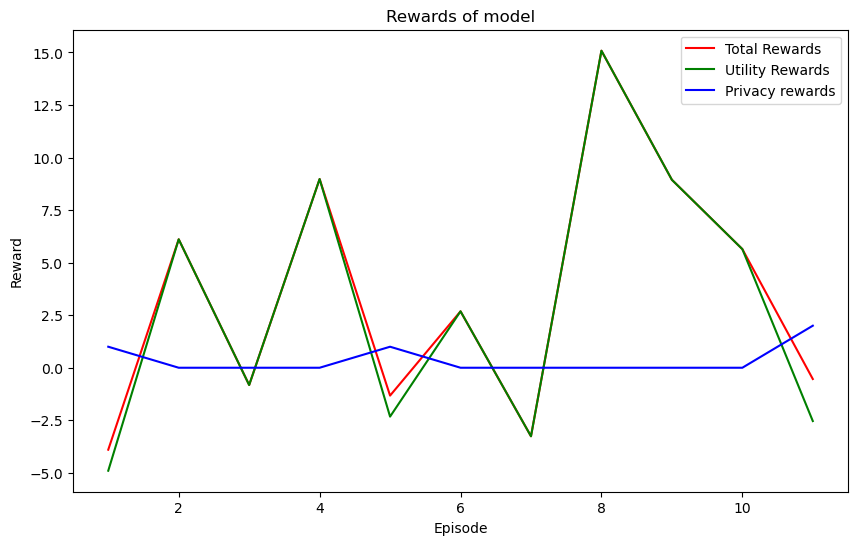

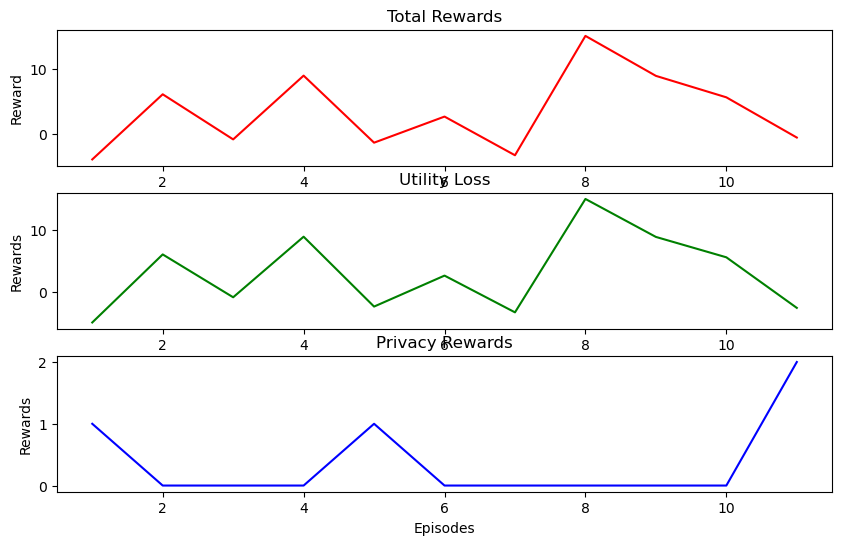

Episode:  11
lrt:  tensor(-3.8571e+29)
preward:  tensor(0.)
ureward:  [0.30175838]
lrt:  tensor(-3.8571e+29)
preward:  tensor(0.)
ureward:  [0.63907826]
lrt:  tensor(-3.8571e+29)
preward:  tensor(0.)
ureward:  [0.5139642]
lrt:  tensor(-3.8571e+29)
preward:  tensor(0.)
ureward:  [1.2844837]
lrt:  tensor(-3.8571e+29)
preward:  tensor(0.)
ureward:  [1.1553494]
lrt:  tensor(-3.8571e+29)
preward:  tensor(0.)
ureward:  [1.5269706]
lrt:  tensor(-3.8571e+29)
preward:  tensor(0.)
ureward:  [1.8395301]
lrt:  tensor(-3.8571e+29)
preward:  tensor(0.)
ureward:  [2.6177485]
lrt:  tensor(-3.8571e+29)
preward:  tensor(0.)
ureward:  [2.6362634]
lrt:  tensor(-3.8571e+29)
preward:  tensor(0.)
ureward:  [2.6212332]
Episode:  12
lrt:  tensor(-5.4928e+29)
preward:  tensor(0.)
ureward:  [-0.19317614]
lrt:  tensor(-5.4930e+29)
preward:  tensor(0.)
ureward:  [0.29145908]
lrt:  tensor(-5.4930e+29)
preward:  tensor(0.)
ureward:  [0.02205986]
lrt:  tensor(-2.4199e+35)
preward:  tensor(0.)
ureward:  [0.69205415]
l

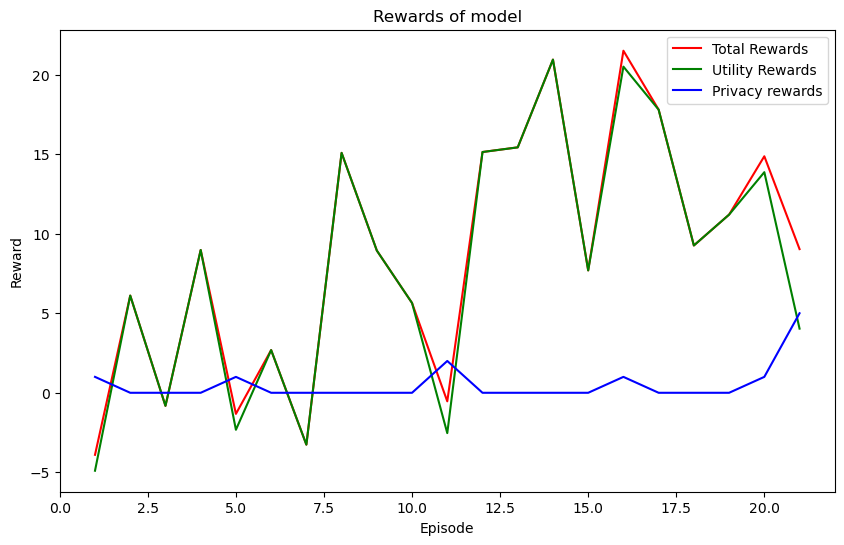

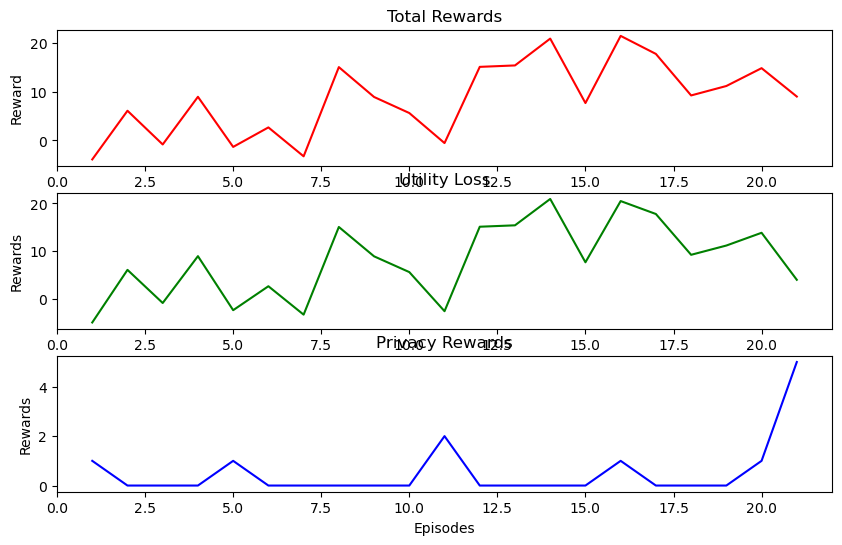

Episode:  21
lrt:  tensor(0.)
preward:  tensor(1.)
ureward:  [0.76594937]
lrt:  tensor(-10259.9619)
preward:  tensor(0.)
ureward:  [1.7659494]
lrt:  tensor(-12194.9463)
preward:  tensor(0.)
ureward:  [2.1431448]
lrt:  tensor(-12194.9463)
preward:  tensor(0.)
ureward:  [2.6906595]
lrt:  tensor(-12240.3447)
preward:  tensor(0.)
ureward:  [3.6906595]
lrt:  tensor(-12240.3447)
preward:  tensor(0.)
ureward:  [4.6906595]
lrt:  tensor(-7.9862e+10)
preward:  tensor(0.)
ureward:  [5.436595]
lrt:  tensor(-7.9862e+10)
preward:  tensor(0.)
ureward:  [5.78206]
lrt:  tensor(-7.9862e+10)
preward:  tensor(0.)
ureward:  [6.4283466]
lrt:  tensor(-7.9862e+10)
preward:  tensor(0.)
ureward:  [6.631899]
Episode:  22
lrt:  tensor(-2.3712e+17)
preward:  tensor(0.)
ureward:  [0.6013919]
lrt:  tensor(-2.4812e+27)
preward:  tensor(0.)
ureward:  [1.6013919]
lrt:  tensor(-5.5670e+29)
preward:  tensor(0.)
ureward:  [2.471891]
lrt:  tensor(-5.5670e+29)
preward:  tensor(0.)
ureward:  [3.471891]
lrt:  tensor(-5.5670e+

KeyboardInterrupt: 

In [14]:
%load_ext autoreload
%autoreload 2
from environment import BeaconEnv
from ppo import PPO
from engine import train

def main():
    env = BeaconEnv(args, beacon, maf_values, binary)
    state_dim = args.beacon_size * args.gene_size * 4
    action_dim = env.action_space.shape[0]

    # initialize a PPO agent
    ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

    train(args, env, ppo_agent)

if __name__ == '__main__':
    main()